##### 三类股票分类，
##### 使用未来三天的平均change来作为标签值y，并用0.33, 0.67分位值作为三类标签的划分边界

##### 数据: A股数据 
##### 模型:  LSTM


In [1]:
import pandas as pd
from pandas import DataFrame
import numpy as np
from numpy import row_stack,column_stack
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter, WeekdayLocator, DayLocator, MONDAY,YEARLY
# from mpl_finance import quotes_historical_yahoo_ohlc, candlestick_ohlc
from matplotlib.pylab import date2num
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Activation,Dropout
import tushare as ts
import datetime
import time

d:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


### softmax三类分类写不出来，用回归代替

### 加工数据

In [2]:
ts.set_token('29ea8fa19e717f1a3d3618796f87067ee07219783a9e01422eb90ef8')
pro = ts.pro_api()

df_ashare = pro.index_daily(ts_code='000001.SH',start_date = '20160401', end_date = '20170930')
df_ashare = df_ashare.iloc[::-1]
df_ashare.head()
df_ashare.to_csv('Ashare-from-20160401-to-20170930.csv', index=False)

df_ashare = pd.read_csv('Ashare-from-20160401-to-20170930.csv')
df_ashare.head()

,ts_code,trade_date,close,open,high,low,pre_close,change,pct_chg,vol,amount
0,000001.SH,20160401,3009.530,2997.088,3009.673,2956.247,3003.915,5.615,0.1869,206545866.0,2.175205e+08
1,000001.SH,20160405,3053.065,3000.938,3057.330,2993.148,3009.530,43.535,1.4466,256730344.0,2.766547e+08
2,000001.SH,20160406,3050.592,3039.745,3059.794,3029.005,3053.065,-2.473,-0.0810,232262051.0,2.549146e+08
3,000001.SH,20160407,3008.420,3058.339,3062.358,3007.060,3050.592,-42.172,-1.3824,220919506.0,2.439618e+08
4,000001.SH,20160408,2984.958,2988.200,2996.171,2960.460,3008.420,-23.462,-0.7799,187904633.0,2.073371e+08


In [3]:
input_data = df_ashare[['trade_date', 'open','high','low','pre_close','change','pct_chg','vol','amount','close']]

In [4]:
# input_data['change'].quantile([0.33,0.5, 0.67,])
quantile033 = input_data['change'].quantile([0.33]).iloc[0]
quantile067 = input_data['change'].quantile([0.67]).iloc[0]

In [5]:
quantile033, quantile067

(-6.425463999999998, 7.28)

In [6]:
input_data['change'].median()

2.0669999999999997

In [7]:
data = input_data['change'].quantile([0.33,])

In [8]:
data.iloc[0]

-6.425463999999998

In [9]:
change = input_data['change']

In [10]:
ave_change_column = [ ]
for i in range(0, len(change)):
    if i >= len(change) - 3:
        ave_change = change[i]
        
    else:
        ave_change = (change[i+1] + change[i+2] + change[i+3]) / 3
    
    ave_change_column.append(ave_change)
#     if ave_change < quantile033:
#         trend_column.append(-1)
#     elif quantile033 <= ave_change <= quantile067:
#         trend_column.append(0)
#     else:
#         trend_column.append(1)


In [11]:
len(change) , len(ave_change_column)

(369, 369)

In [12]:
input_data['ave_change'] = ave_change_column

In [13]:
input_data.head(15)

,trade_date,open,high,low,pre_close,change,pct_chg,vol,amount,close,ave_change
0,20160401,2997.088,3009.673,2956.247,3003.915,5.615,0.1869,206545866.0,2.175205e+08,3009.530,-0.370000
1,20160405,3000.938,3057.330,2993.148,3009.530,43.535,1.4466,256730344.0,2.766547e+08,3053.065,-22.702333
2,20160406,3039.745,3059.794,3029.005,3053.065,-2.473,-0.0810,232262051.0,2.549146e+08,3050.592,-5.545000
3,20160407,3058.339,3062.358,3007.060,3050.592,-42.172,-1.3824,220919506.0,2.439618e+08,3008.420,5.075333
4,20160408,2988.200,2996.171,2960.460,3008.420,-23.462,-0.7799,187904633.0,2.073371e+08,2984.958,27.226667
5,20160411,3006.909,3048.977,3006.909,2984.958,48.999,1.6415,220018324.0,2.523284e+08,3033.957,16.135000
6,20160412,3031.301,3036.825,3001.315,3033.957,-10.311,-0.3399,182718668.0,2.070798e+08,3023.646,18.157000
7,20160413,3041.358,3097.165,3041.358,3023.646,42.992,1.4219,310003246.0,3.314207e+08,3066.638,-10.992667
8,20160414,3080.090,3086.698,3056.989,3066.638,15.724,0.5127,208237830.0,2.350561e+08,3082.362,-13.179667
9,20160415,3085.026,3089.951,3066.872,3082.362,-4.245,-0.1377,189613051.0,2.241413e+08,3078.117,-35.177667


In [14]:
# 增加一个新闻指标数据

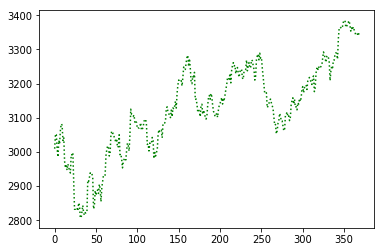

In [15]:
fig2 = plt.figure()
plt.plot(input_data['close'], 'g:')
plt.show()

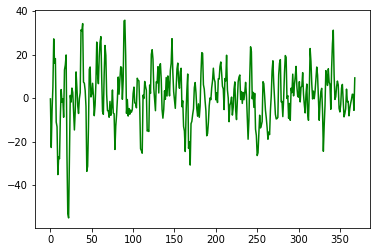

In [16]:
fig2 = plt.figure()
plt.plot(input_data['ave_change'], 'g-')
plt.show()

In [17]:
temp_news = input_data['ave_change'].astype(int)
# temp_news = temp_news + random.randint(-2,2)
temp_news = temp_news * 2

In [18]:
temp_news.head()

0     0
1   -44
2   -10
3    10
4    54
Name: ave_change, dtype: int32

In [19]:
input_data.shape

(369, 11)

In [20]:
input_data['news_index'] = temp_news

In [21]:
temp_data = input_data['ave_change'].values.reshape(-1, 1)
# temp_data.shape, input_data['ave_change'].shape
news_scaler = MinMaxScaler()
news_trend = news_scaler.fit_transform(temp_data)


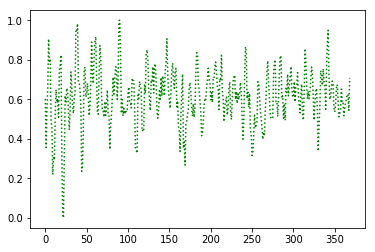

In [22]:
fig2 = plt.figure()
plt.plot(news_trend, 'g:')
plt.show()

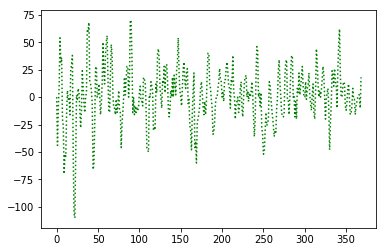

In [23]:
fig2 = plt.figure()
plt.plot(temp_news, 'g:')
plt.show()

In [24]:
temp_column = input_data.pop('ave_change')
input_data['ave_change'] = temp_column

In [25]:
input_data.head()

,trade_date,open,high,low,pre_close,change,pct_chg,vol,amount,close,news_index,ave_change
0,20160401,2997.088,3009.673,2956.247,3003.915,5.615,0.1869,206545866.0,2.175205e+08,3009.530,0,-0.370000
1,20160405,3000.938,3057.330,2993.148,3009.530,43.535,1.4466,256730344.0,2.766547e+08,3053.065,-44,-22.702333
2,20160406,3039.745,3059.794,3029.005,3053.065,-2.473,-0.0810,232262051.0,2.549146e+08,3050.592,-10,-5.545000
3,20160407,3058.339,3062.358,3007.060,3050.592,-42.172,-1.3824,220919506.0,2.439618e+08,3008.420,10,5.075333
4,20160408,2988.200,2996.171,2960.460,3008.420,-23.462,-0.7799,187904633.0,2.073371e+08,2984.958,54,27.226667


In [26]:
data = input_data.values

dd1=input_data.sort_index()

dd2=dd1.values.flatten()

dd3=pd.DataFrame(dd1['close'])

In [27]:
def load_data(df, sequence_length=10, split=0.8):
    # 转为float型
    data_all = np.array(df.astype(float))
    # 标准化
    x_scaler = MinMaxScaler()
    data_all[:, :-1] = x_scaler.fit_transform(data_all[:, :-1])
    data = []
    for i in range(len(data_all) - sequence_length - 1):
        data.append(data_all[i: i + sequence_length + 1])
    reshaped_data = np.array(data).astype('float64')
    x = reshaped_data[:, :-1]
    y = reshaped_data[:, -1][:, -1]
    scaler = MinMaxScaler()
    y = scaler.fit_transform(y.reshape(-1, 1))
    split_boundary = int(reshaped_data.shape[0] * split)
    train_x = x[: split_boundary]
    test_x = x[split_boundary:]

    train_y = y[: split_boundary]
    test_y = y[split_boundary:]

    return train_x, train_y, test_x, test_y, scaler

In [28]:
def build_model(layers):
    model = Sequential()

    # By setting return_sequences to True we are able to stack another LSTM layer
    model.add(LSTM(
        input_dim=layers[0],
        output_dim=layers[1],
        return_sequences=True))
    model.add(Dropout(0.5))

    model.add(LSTM(
        layers[2],
        return_sequences=False))
    model.add(Dropout(0.5))

    model.add(Dense(
        output_dim=layers[3]))
    model.add(Activation("linear"))

    start = time.time()
    model.compile(loss="mse", optimizer="adam", metrics=['accuracy'])
    print("Compilation Time : ", time.time() - start)
    return model

In [29]:
def train_model(train_x, train_y, test_x, test_y):
    model = build_model([train_x.shape[2], train_x.shape[1], 100, 1])

    try:
        model.fit(train_x, train_y, batch_size=40, nb_epoch=200, validation_split=0.1)
        predict = model.predict(test_x)
        predict = np.reshape(predict, (predict.size, ))
    except KeyboardInterrupt:
        print(predict)
        print(test_y)
#     print(predict)
#     print(test_y)
    try:
        fig = plt.figure(1)
        plt.plot(predict, 'r:')
        plt.plot(test_y, 'g-')
        plt.legend(['predict', 'true'])
    except Exception as e:
        print(e)
    return predict, test_y , model

In [30]:
train_x, train_y, test_x, test_y, scaler =load_data(dd1, sequence_length=20, split=0.8)

In [31]:
print("train_x", train_x.shape)
print("train_y", train_y.shape)
print("test_x", test_x.shape)
print("test_y", test_y.shape)

train_x (278, 20, 12)
train_y (278, 1)
test_x (70, 20, 12)
test_y (70, 1)


d:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  
d:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(return_sequences=True, input_shape=(None, 12), units=20)`
  
d:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(units=1)`
d:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  """


Compilation Time :  0.03344249725341797
Train on 250 samples, validate on 28 samples
Epoch 1/200
250/250 [==============================] - 2s 10ms/step - loss: 0.1558 - acc: 0.0080 - val_loss: 0.0402 - val_acc: 0.0000e+00
Epoch 2/200
250/250 [==============================] - 0s 956us/step - loss: 0.0815 - acc: 0.0000e+00 - val_loss: 0.0296 - val_acc: 0.0000e+00
Epoch 3/200
250/250 [==============================] - 0s 1ms/step - loss: 0.0608 - acc: 0.0040 - val_loss: 0.0126 - val_acc: 0.0000e+00
Epoch 4/200
250/250 [==============================] - 0s 906us/step - loss: 0.0410 - acc: 0.0040 - val_loss: 0.0165 - val_acc: 0.0000e+00
Epoch 5/200
250/250 [==============================] - 0s 977us/step - loss: 0.0389 - acc: 0.0040 - val_loss: 0.0112 - val_acc: 0.0000e+00
Epoch 6/200
250/250 [==============================] - 0s 969us/step - loss: 0.0352 - acc: 0.0040 - val_loss: 0.0112 - val_acc: 0.0000e+00
Epoch 7/200
250/250 [==============================] - 0s 925us/step - loss: 0.0

Epoch 59/200
250/250 [==============================] - 0s 822us/step - loss: 0.0176 - acc: 0.0080 - val_loss: 0.0075 - val_acc: 0.0000e+00
Epoch 60/200
250/250 [==============================] - 0s 842us/step - loss: 0.0161 - acc: 0.0080 - val_loss: 0.0081 - val_acc: 0.0000e+00
Epoch 61/200
250/250 [==============================] - 0s 838us/step - loss: 0.0173 - acc: 0.0080 - val_loss: 0.0071 - val_acc: 0.0000e+00
Epoch 62/200
250/250 [==============================] - 0s 870us/step - loss: 0.0151 - acc: 0.0080 - val_loss: 0.0078 - val_acc: 0.0000e+00
Epoch 63/200
250/250 [==============================] - 0s 774us/step - loss: 0.0191 - acc: 0.0080 - val_loss: 0.0075 - val_acc: 0.0000e+00
Epoch 64/200
250/250 [==============================] - 0s 886us/step - loss: 0.0155 - acc: 0.0080 - val_loss: 0.0095 - val_acc: 0.0000e+00
Epoch 65/200
250/250 [==============================] - 0s 738us/step - loss: 0.0150 - acc: 0.0080 - val_loss: 0.0069 - val_acc: 0.0000e+00
Epoch 66/200
250/250

250/250 [==============================] - 0s 930us/step - loss: 0.0133 - acc: 0.0080 - val_loss: 0.0083 - val_acc: 0.0000e+00
Epoch 118/200
250/250 [==============================] - 0s 1ms/step - loss: 0.0140 - acc: 0.0080 - val_loss: 0.0079 - val_acc: 0.0000e+00
Epoch 119/200
250/250 [==============================] - 0s 1ms/step - loss: 0.0154 - acc: 0.0080 - val_loss: 0.0084 - val_acc: 0.0000e+00
Epoch 120/200
250/250 [==============================] - 0s 989us/step - loss: 0.0169 - acc: 0.0080 - val_loss: 0.0071 - val_acc: 0.0000e+00
Epoch 121/200
250/250 [==============================] - 0s 834us/step - loss: 0.0132 - acc: 0.0080 - val_loss: 0.0069 - val_acc: 0.0000e+00
Epoch 122/200
250/250 [==============================] - 0s 858us/step - loss: 0.0119 - acc: 0.0080 - val_loss: 0.0081 - val_acc: 0.0000e+00
Epoch 123/200
250/250 [==============================] - 0s 846us/step - loss: 0.0150 - acc: 0.0080 - val_loss: 0.0073 - val_acc: 0.0000e+00
Epoch 124/200
250/250 [========

250/250 [==============================] - 0s 898us/step - loss: 0.0109 - acc: 0.0080 - val_loss: 0.0076 - val_acc: 0.0000e+00
Epoch 176/200
250/250 [==============================] - 0s 802us/step - loss: 0.0117 - acc: 0.0080 - val_loss: 0.0087 - val_acc: 0.0000e+00
Epoch 177/200
250/250 [==============================] - 0s 854us/step - loss: 0.0127 - acc: 0.0080 - val_loss: 0.0075 - val_acc: 0.0000e+00
Epoch 178/200
250/250 [==============================] - 0s 918us/step - loss: 0.0122 - acc: 0.0080 - val_loss: 0.0076 - val_acc: 0.0000e+00
Epoch 179/200
250/250 [==============================] - 0s 806us/step - loss: 0.0125 - acc: 0.0080 - val_loss: 0.0090 - val_acc: 0.0000e+00
Epoch 180/200
250/250 [==============================] - 0s 850us/step - loss: 0.0121 - acc: 0.0080 - val_loss: 0.0080 - val_acc: 0.0000e+00
Epoch 181/200
250/250 [==============================] - 0s 782us/step - loss: 0.0116 - acc: 0.0080 - val_loss: 0.0075 - val_acc: 0.0000e+00
Epoch 182/200
250/250 [====

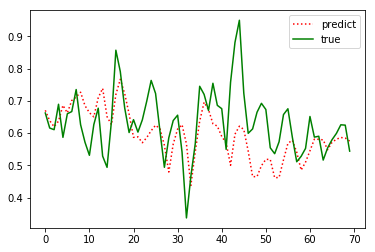

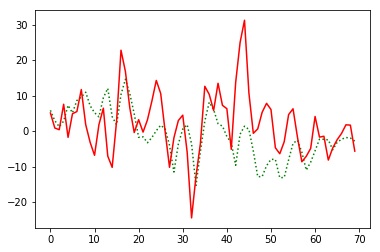

In [32]:
predict_y, test_y, model = train_model(train_x, train_y, test_x, test_y)
predict_y = scaler.inverse_transform([[i] for i in predict_y])
test_y = scaler.inverse_transform(test_y)
fig2 = plt.figure(2)
plt.plot(predict_y, 'g:')
plt.plot(test_y, 'r-')
plt.show()


In [33]:
trend_list = [1,]
for i in range(1, len(predict_y)):
    if predict_y[i] <= quantile033:
        trend_list.append(-1)
    elif quantile033 <= predict_y[i] <= quantile067:
        trend_list.append(0)
    else:
        trend_list.append(1)

real_trend_list = [1,]
for i in range(1, len(test_y)):
    if test_y[i] <= quantile033:
        real_trend_list.append(-1)
    elif quantile033 <= test_y[i] <= quantile067:
        real_trend_list.append(0)
    else:
        real_trend_list.append(1)
        
true_count = 0
false_count = 0


print(len(test_y), len(predict_y))

pair_list = []

for i in range(len(predict_y)-1):
    pair_list.append([real_trend_list[i], trend_list[i]])
    if real_trend_list[i] == trend_list[i]:
        true_count = true_count + 1
    else:
        false_count = false_count + 1

# print(pair_list)
print(true_count, false_count)


70 70
38 31


In [34]:
len(real_trend_list) , len(trend_list)

(70, 70)

In [35]:
accuracy = true_count/ len(predict_y)
accuracy
#0.6657303370786517

0.5428571428571428

In [36]:
from collections import Counter

result = Counter(trend_list)
print ("预测数据", result)
result = Counter(real_trend_list)
print ("真实数据", result)

预测数据 Counter({0: 47, -1: 13, 1: 10})
真实数据 Counter({0: 45, 1: 16, -1: 9})


In [37]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, None, 20)          2640      
_________________________________________________________________
dropout_1 (Dropout)          (None, None, 20)          0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 100)               48400     
_________________________________________________________________
dropout_2 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
_________________________________________________________________
activation_1 (Activation)    (None, 1)                 0         
Total params: 51,141
Trainable params: 51,141
Non-trainable params: 0
_________________________________________________________________


### 画 accuracy图和trend图

In [38]:
%matplotlib qt
plt.clf()
# fig2 = plt.figure()
plt.plot(predict_y, 'b-',label = 'predict ave change')
plt.plot(test_y, 'r-', label = 'true ave change')
plt.title('Model without Sentiment Analysis change price prediction')
plt.xlabel('Days')
plt.ylabel('change price')
plt.legend()
plt.show()

In [39]:
real_df = pd.DataFrame(real_trend_list)
pred_df = pd.DataFrame(trend_list)
acc_df = pd.concat((real_df[0],pred_df[0]), axis=1)
acc_df.head(5)

,0,0
0,1,1
1,0,0
2,0,0
3,1,0
4,0,0


In [40]:
temp_list = []
temp_df =  real_df[0] - pred_df[0]
for i in range(0, len(temp_df)):
    temp_list.append([i, temp_df[i]])

In [41]:
%matplotlib qt
plt.clf()
# plt.figure()
plt.scatter( *zip(*temp_list), )
# plt.scatter(real_df.index.values, pred_df[0],color='blue', marker='^')
# plt.scatter(real_df.index.values, real_df[0],color='red', marker='.')
plt.title('Model without Sentiment Analysis = {}'.format(accuracy))
plt.xlabel('Days')
plt.ylabel('Trend Prediction')
plt.show()

In [42]:
acc_df.to_csv('outputtrendwithoutsentiment.csv', index = False)